In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from HelperFunctions import *
from PtOccupancyFunctions import *
import scipy.integrate
import pprint
from FindDataFunctions import *
from pprint import pprint
from IPython.core.display import display, HTML
from matplotlib import cm
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [83]:
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/bimodal/output/3Alpha900Beta3000DistDifferentReqs60Mu/"

In [249]:
keys = ["reqs","dist","frac_comm_orig_dest","drt","dcut","l"]
values = [None,"3000","0","1000",None,None]

def readData():
    saved_path = os.path.join(path, "saved_wptoccs.pkl")
    
    # Load bimodal dataframe
    if os.path.isfile(saved_path):
        df = pd.read_pickle(saved_path)
    else:
        dcut_dirs = getDirs(path, keys, values)
        cols = ["requests","dcut", "l", "occupancy", "detour", "servability", "req_mean_dist", "drt_travel_time_normalized",
                "drt_wait_time_normalized", "drt_wait_time", "drt_distance", "cummulative_dist_drt",
                "cummulative_dist_drt_unshared", "pkm_drt", "idle_frac", "drt_ride_time", "av_pt_occs"]
        df = pd.DataFrame(np.full((len(dcut_dirs),len(cols)), np.nan), columns=cols)
        for i,e in enumerate(dcut_dirs):
            row = df.iloc[i,:]
            try:
                row.loc["requests"] = float(e[0])
                row.loc["dcut"] = float(e[4])
                row.loc["l"] = float(e[5])
                dic = e[-1]
                row.loc["occupancy"], row.loc["idle_frac"] = getDrtOccupandyAndStandingFrac(dic, False, False)
                df_detour = getDrtDetours(dic)
                row.loc["detour"] = df_detour["distanceDetour"].mean()
                trip_succ = getTripSuccess(dic)
                row.loc["servability"] = len(trip_succ[trip_succ["tripSuccess"]]) / len(trip_succ)
                df_persons = getPersons(dic)
                row.loc["req_mean_dist"] = df_persons["mean_dist"].mean()
                drt_trips, drt_trips_perperson = getDrtTrips(dic)
                row.loc["cummulative_dist_drt"] = getDrtVehicleDistances(dic).sum()
                row.loc["cummulative_dist_drt_unshared"] = drt_trips["direcTravelDistance_m"].sum()
                df_detour = df_detour.set_index("person")
                row.loc["drt_wait_time"] = drt_trips_perperson["waitTime"].mean()
                row.loc["drt_wait_time_normalized"] = (drt_trips_perperson["waitTime"]/df_detour["unsharedTime"]).mean()
                row.loc["drt_travel_time_normalized"] = (drt_trips_perperson["travelTime"]/df_detour["unsharedTime"]).mean()
                row.loc["drt_distance"] = drt_trips_perperson["travelDistance_m"].mean()
                _, row.loc["pkm_drt"] = getModeStats(dic, [], ["drt"])
                row.loc["drt_ride_time"] = drt_trips_perperson["travelTime"].mean()
                row.loc["av_pt_occs"], _ = getPtOccupancy(dic)
            except KeyError:
                print("KeyError")
                pass

            print("-----")

        df.to_pickle(saved_path)

    
    df = df.sort_values(["dcut", "l"])
    display(np.unique(df["dcut"]))
#     display(df["l"])
#     display(df["dcut"])
    df["l"] /= df["req_mean_dist"].mean()
    df["dcut"] /= df["req_mean_dist"].mean()
    df["drt_wait_time"] /= df["req_mean_dist"].mean()/(30/3.6)
    df["drt_ride_time"] /= df["req_mean_dist"].mean()/(30/3.6)
#     data = np.einsum("ijk->jik", data)
    
    return df

---
# Visualization

In [250]:
# reqs = [10000, 15000, 20000, 25000, 30000]
# dfs = []
# for req in reqs:
#     df, df_car = readData(req)
#     df["efficiency"] = df["occupancy"]/df["detour"]
#     dfs.append(df)
df = readData()

print(len(df))
df_served = df[np.isclose(df["servability"],1,atol=0.01)]
print(len(df_served))
# print(str(df["req_mean_dist"].mean()) + " should be a lot larger than " + str(df["req_mean_dist"].std()))
# req_mean_dist = df["req_mean_dist"].mean()

array([ 200.,  400.,  600.,  800., 1000., 1200., 1400., 1600., 1800.,
       2000., 2200., 2400., 2600., 2800., 3000., 3200., 3400., 3600.,
       3800., 4000., 4200., 4400., 4600., 4800., 5000.])

11875
11875


In [251]:
mean_dist = 3000
beta = 1/6*(np.sqrt(2)+np.log(1+np.sqrt(2)))

def inverseGammaDistUnnormalized(x, d_mean=mean_dist, k=3.1):
    if (x==0):
        return 0
    elif (x>5000):
        return 0
    else:
        z = x/d_mean
        return (z**(-k))*np.exp(-(k-2)/z)

normalization_inverse_gamma = scipy.integrate.quad(inverseGammaDistUnnormalized,0,np.infty)[0]

print("Normalization factor for InverseGamma distribution: ", normalization_inverse_gamma)

def inverseGammaDist_(x):
    return inverseGammaDistUnnormalized(x)/normalization_inverse_gamma

rpr_ = lambda x: x*inverseGammaDist_(x)

def getBimFrac_(dcut):
    return scipy.integrate.quad(inverseGammaDist, dcut, np.infty)[0]

def getBimAvDist_(ell):
    return 2*beta*ell

def getBimAvDistOneLeg_(ell):
    return beta*ell

def getBimFracAvDist_(ell, dcut):
    return getBimFrac_(dcut)*getBimAvDist_(ell)

def getUniFrac_(dcut):
    return 1 - getBimFrac_(dcut)

def getUniAvDist_(dcut):
    new_norm = scipy.integrate.quad(inverseGammaDist, 0, dcut)[0]
    new_rpr_ = lambda r: rpr_(r)/new_norm
    return scipy.integrate.quad(new_rpr_, 0, dcut)[0]

def getUniFracAvDist_(dcut):
    return scipy.integrate.quad(rpr_, 0, dcut)[0]

rpr = np.vectorize(rpr_)
inverseGammaDist = np.vectorize(inverseGammaDist_)
getBimFrac = np.vectorize(getBimFrac_)
getUniFrac = np.vectorize(getUniFrac_)
getUniAvDist = np.vectorize(getUniAvDist_)
getBimAvDist = np.vectorize(getBimAvDist_)
getBimAvDistOneLeg = np.vectorize(getBimAvDistOneLeg_)
getBimFracAvDist = np.vectorize(getBimFracAvDist_)
getUniFracAvDist = np.vectorize(getUniFracAvDist_)
average_dist_theory = scipy.integrate.quad(rpr_,0,np.infty)[0]

Normalization factor for InverseGamma distribution:  2253.726079706043


In [252]:
length_scale = df["req_mean_dist"].mean()

# Parameters
L=10000
v_drt = 30/3.6
B = 1000/L**2

# More computations
df_served["pbusy"] = 1 - df_served["idle_frac"]
df_served["uni_frac"] = getUniFrac(df_served["dcut"]*length_scale)
df_served["bi_frac"] = 1 - df_served["uni_frac"]
df_served["drt_dist"] = (getUniFracAvDist(df_served["dcut"]*length_scale) + \
                         getBimFracAvDist(df_served["l"]*length_scale, df_served["dcut"]*length_scale)) /\
                        (1+df_served["bi_frac"])
df_served["pbBtilde"] = df_served["pbusy"]*df_served["drt_dist"]**2*B

# computation of nu,E,...
df_served["nu"] = 1/(3600*9)*(1+df_served["bi_frac"])
df_served["E"] = df_served["requests"]/L**2
df_served["Λ"] = df_served["drt_dist"]**3*df_served["E"]*df_served["nu"]/v_drt
df_served["efficiency"] = df_served["cummulative_dist_drt_unshared"]/df_served["cummulative_dist_drt"]

In [253]:
df_served["D1"] = getUniAvDist(df_served["dcut"]*length_scale)
df_served["D2"] = getBimAvDistOneLeg(df_served["l"]*length_scale)

In [88]:
# df_served900mu = df_served
# df_served900mu["mu"] = 900
# # df_served60mu = df_served
# df_served60mu["mu"] = 60

In [89]:
# df_served = pd.concat([df_served60mu, df_served900mu])

In [128]:
unique_dc = np.unique(df_served["dcut"])
unique_l = np.unique(df_served["l"])
print(unique_dc)

[0.10371096 0.20742193 0.31113289 0.41484385 0.51855482 0.62226578
 0.72597674 0.8296877  0.93339867 1.03710963 1.14082059 1.24453156
 1.34824252 1.45195348 1.55566445 1.65937541 1.76308637 1.86679733
 1.9705083  2.07421926 2.17793022 2.28164119 2.38535215 2.48906311
 2.59277408]
[0.10371096 0.20742193 0.31113289 0.41484385 0.51855482 0.62226578
 0.72597674 0.8296877  0.93339867 1.03710963 1.14082059 1.24453156
 1.34824252 1.45195348 1.55566445 1.65937541 1.76308637 1.86679733
 1.9705083  2.07421926 2.17793022 2.28164119 2.38535215 2.48906311
 2.59277408]


In [91]:
def power(x,b):
    return x**b

df_uni = df_served[df_served["bi_frac"] == 0].copy()
df_bim = df_served[df_served["bi_frac"] != 0].copy()

popt, pcov = curve_fit(power, df_uni["Λ"], df_uni["efficiency"])
print(popt)

[0.1445785]


In [266]:
# # data60mu = df_served[df_served["mu"] == 60].pivot(index="l", columns="dcut", values=["efficiency"])
# data60mu = df_served[df_served["mu"] == 60].sort_values(["l", "dcut", "requests"]).reset_index()
# display(data60mu.head())
# # data900mu = df_served[df_served["mu"] == 900].pivot(index="l", columns="dcut", values=["efficiency"])
# data900mu = df_served[df_served["mu"] == 900].sort_values(["l", "dcut", "requests"]).reset_index()

# fig, ax = plt.subplots(constrained_layout=True)
# ax.scatter(data60mu["Λ"], data900mu["efficiency"]/data60mu["efficiency"], s=1)
# ax.set_xlabel(r"$\Lambda$")
# ax.set_ylabel(r"$\eta_1/\eta_2$")

# plt.show()

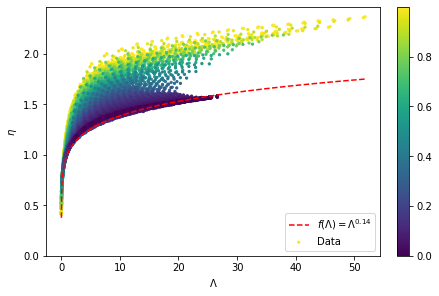

In [267]:
%matplotlib inline

# df_plot = df_served[(df["l"] == unique_l[15]) & (df["dcut"] == unique_dc[5])]
df_plot = df_served[:]
# df_plot = df_served[df_served["l"] < 1]
# print(np.unique(df_plot["mu"]))
fig, ax = plt.subplots(constrained_layout=True)
im = ax.scatter(df_plot["Λ"], df_plot["efficiency"], c=df_plot["bi_frac"], s=5, label="Data")
# im = ax.scatter(df_plot["Λ"], df_plot["efficiency"]/h_appr(df_plot["bi_frac"]), c=df_plot["bi_frac"], s=5, label="Data")
# im = ax.scatter(df_plot["Λ"], df_plot["drt_wait_time"], c=df_plot["bi_frac"], s=5, label="Data")
fig.colorbar(im)
ax.set_xlabel(r"$\Lambda$")
ax.set_ylabel(r"$\eta$")

b = 0.14163321
eta_fit_unim = lambda l: power(l, b)

x = np.linspace(0.001, df_served["Λ"].max(), 1000)
ax.plot(x, eta_fit_unim(x), color="red", ls="--", label=rf"$f(\Lambda)=\Lambda^{{{round(popt[0],2)}}}$")
ax.set_xlabel(r"$\Lambda$")
ax.set_ylabel(r"$\eta$")
ax.legend(loc="lower right")
ax.set_ylim((0,None))
# ax.set_xscale('log')
# ax.set_yscale('log')

# fig.savefig("Figures/BimodalEfficiency_hrescaledLog.jpg", dpi=600)
# fig.savefig("Figures/BimodalEfficiencyLog.jpg", dpi=600)
plt.show()
# 60Mu: [1.07301865 0.11899248]

#TODO: p_b*D^2*B als funktion von lambda
#TODO: p_b & p_s als funktion von B

b: 0.14163321

Optimization Result:       fun: 179.54826096528365
 hess_inv: array([[0.0001001]])
      jac: array([3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 22
      nit: 8
     njev: 11
   status: 0
  success: True
        x: array([1.24957808]) 

c : 1.2495780799634797


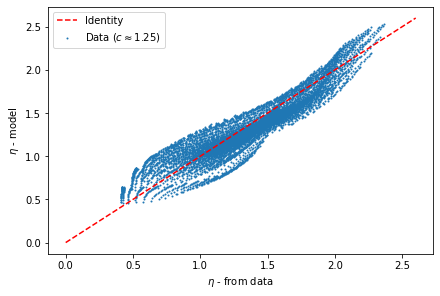

In [262]:
# df_fit = df_served[df_served["Λ"] > 10]
df_fit = df_served[:]
a1 = 1

w = df_fit["uni_frac"]
D1 = df_fit["D1"]
D2 = df_fit["D2"]
E = df_fit["E"]
nu = 1/(3600*9)
print(f"b: {b}\n")

RHS = lambda c: (2-w)/(1/a1*w*(w*D1**3*E*nu/v_drt)**(-b) +\
          c*(1-w)*((1-w)*D2**3*E*nu/v_drt)**(-b))

error_func = lambda c: np.sum((RHS(c) - df_fit["efficiency"])**2)
res = minimize(error_func, [0.5])
print("Optimization Result:", res, "\n")
print(f"c : {res.x[0]}")

fig, ax = plt.subplots(constrained_layout=True)

x,y = df_fit["efficiency"], RHS(*res.x)
ax.scatter(x, y, s=1, label=fr"Data ($c\approx{round(res.x[0],3)}$)")
lin_to = x.max()*1.1
ax.plot([0, lin_to], [0, lin_to], ls="--", c="r", label="Identity")
ax.set_xlabel(r"$\eta$ - from data")
ax.set_ylabel(r"$\eta$ - model")

ax.legend()

# fig.savefig("Figures/BimEffModel_c.jpg", dpi=600)
plt.show()

Optimization Result:       fun: 179.54826096528342
 hess_inv: array([[ 0.01262033, -0.01421613],
       [-0.01421613,  0.01617505]])
      jac: array([3.62396240e-05, 2.67028809e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 54
      nit: 11
     njev: 18
   status: 2
  success: False
        x: array([0.84763826, 0.92104992]) 

1/a1 : 1.1797485380150907, 1/a2 : 1.0857174805882517


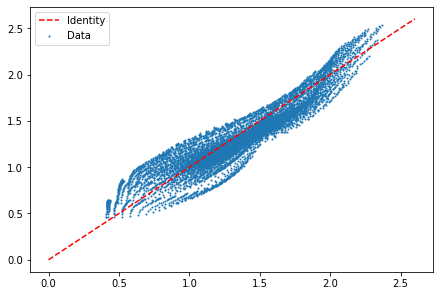

In [258]:
D3 = D2

RHS = lambda a2, a3: (2-w)/(w*(w*D1**3*E*nu/v_drt)**(-b) +\
          1/a2* (1-w)/2*((1-w)/2*D2**3*E*nu/v_drt)**(-b) +\
          1/a3* (1-w)/2*((1-w)/2*D3**3*E*nu/v_drt)**(-b))
          
error_func = lambda x: np.sum((RHS(x[0],x[1]) - df_served["efficiency"])**2)
res = minimize(error_func, [1.5, 1.5])#, bounds=[(0,1),(0,1)])
print("Optimization Result:", res, "\n")
print(f"1/a1 : {1/res.x[0]}, 1/a2 : {1/res.x[1]}")

fig, ax = plt.subplots(constrained_layout=True)

x,y = df_served["efficiency"], RHS(*res.x)
ax.scatter(x, y, s=1, label=f"Data")
lin_to = x.max()*1.1
ax.plot([0, lin_to], [0, lin_to], ls="--", c="r", label="Identity")

ax.legend()

plt.show()

In [96]:
# plt.scatter(df_served["Λ"], df_served["av_pt_occs"], s=2)
# plt.show()

/scratch01.local/hheuer/matsim-bimodal/python_analysis/env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


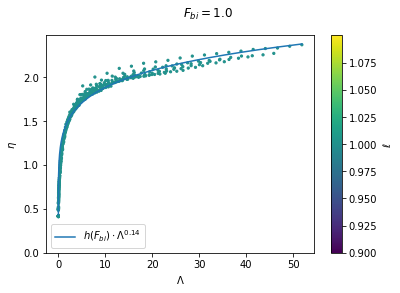

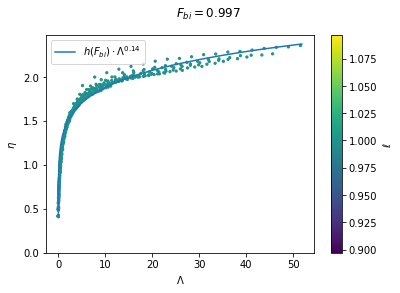

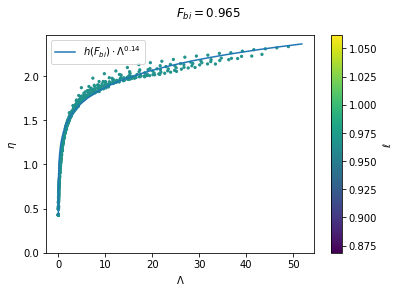

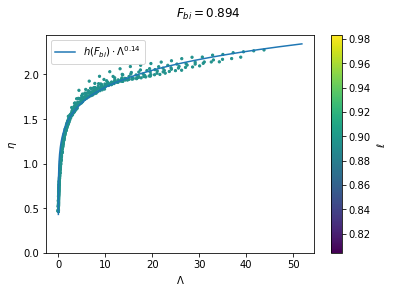

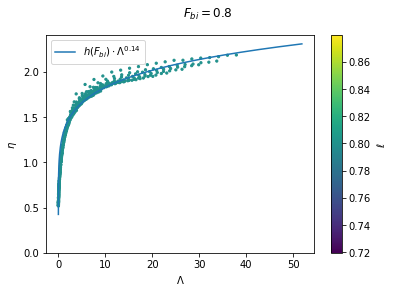

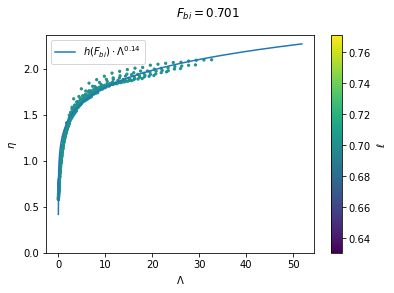

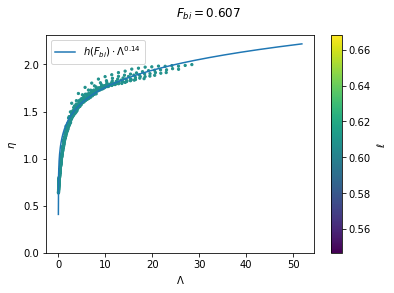

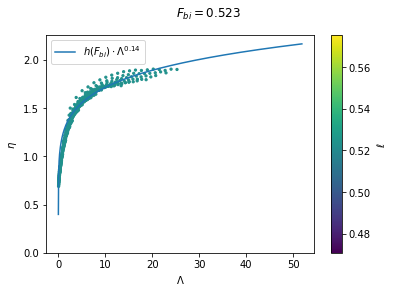

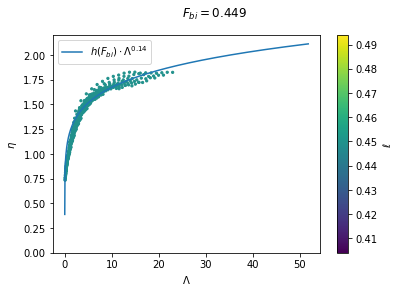

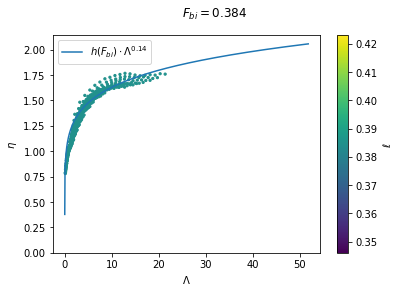

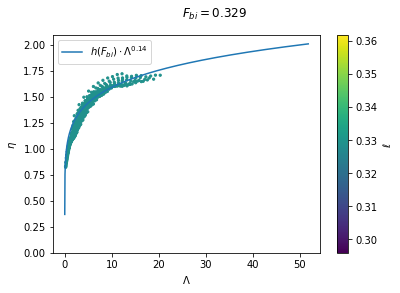

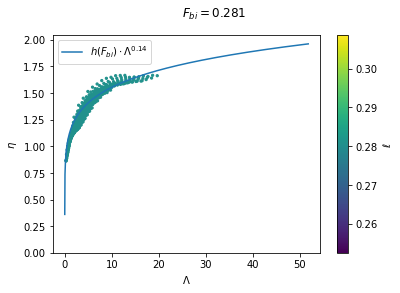

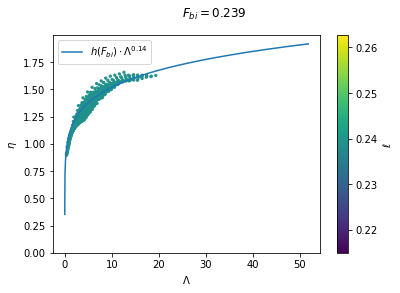

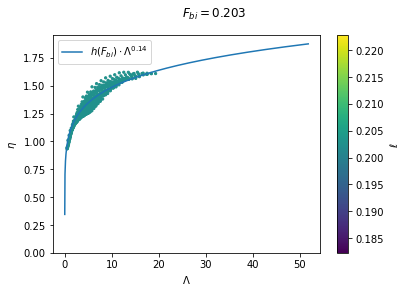

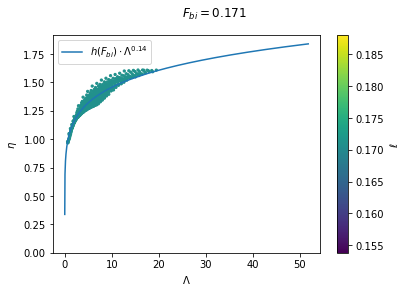

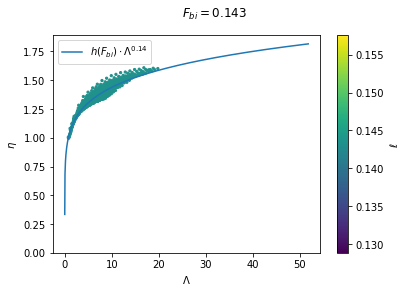

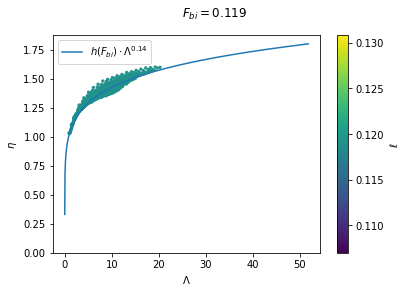

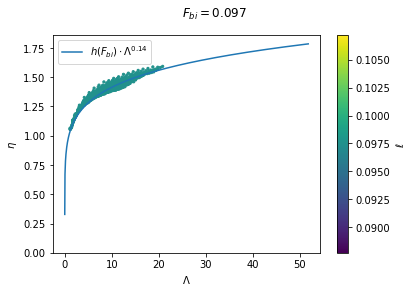

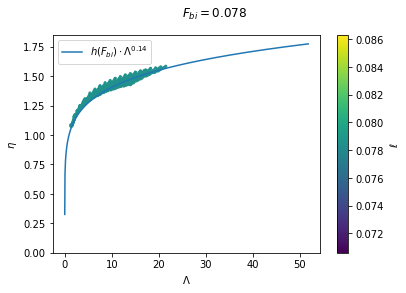

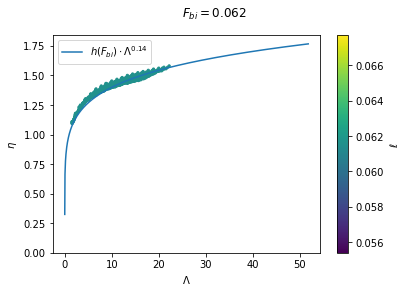

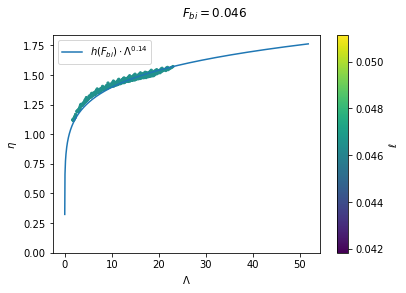

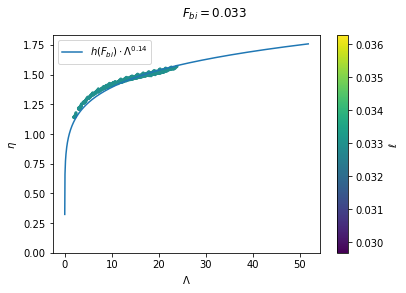

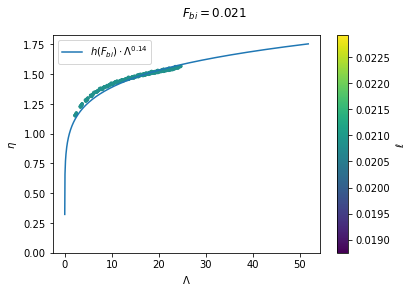

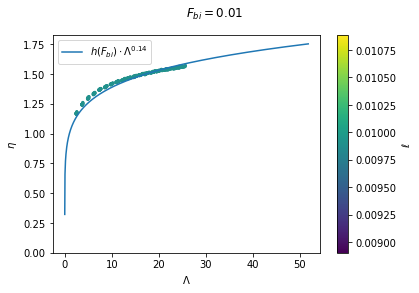

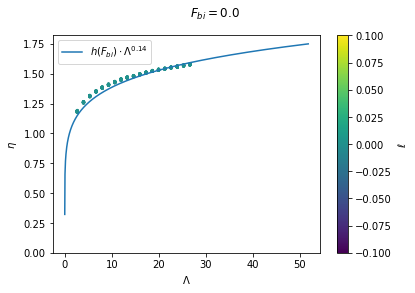

In [120]:
%matplotlib inline

# popt_unimodal = [0.96218933, 0.11344844]
popt_unimodal = [0.93510452, 0.11505979]

# popt = [0.95831991, 0.11305549]

x = np.linspace(df_served["Λ"].min(), df_served["Λ"].max(), 1000)
# df_plot = df_served[(df_served["l"]>0) & (df_served["l"]<1)]
# df_plot = df_served[:]
for dc in unique_dc:
    fig, ax = plt.subplots()
    df_plot = df_served[df_served["dcut"] == dc]
    fbi = df_plot["bi_frac"].iloc[0]
    fbiappr = round(fbi,3)
    im = ax.scatter(df_plot["Λ"], df_plot["efficiency"], c=df_plot["bi_frac"], s=5)
    fig.colorbar(im, label=r"$\ell$")
    ax.plot(x, h_appr(fbi)*eta_fit_unim(x), label=rf"$h(F_{{bi}})\cdot\Lambda^{{{round(popt[0],2)}}}$")
    ax.set_ylim((0,None))
    ax.set_xlabel(r"$\Lambda$")
    ax.set_ylabel(r"$\eta$")
    ax.legend()
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    fig.suptitle(rf"$F_{{bi}} = {fbiappr}$")
#     fig.savefig(f"Figures/BimEffPlots/Fbi{fbiappr}.jpg")


plt.show()
# 60Mu: [1.07301865 0.11899248]

#TODO: p_b*D^2*B als funktion von lambda
#TODO: p_b & p_s als funktion von B

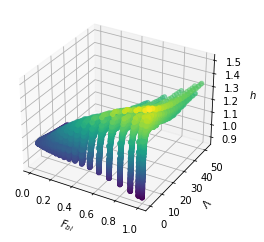

In [98]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

df_bim["h"] = df_bim["efficiency"] / power(df_bim["Λ"], *popt)

ax.scatter(df_bim["bi_frac"], df_bim["Λ"], df_bim["h"], c=df_bim["h"])
# ax.plot_wireframe(X,Y,f_interp(X), color="red")
ax.set_xlabel(r"$F_{bi}$")
ax.set_ylabel(r"$\Lambda$")
ax.set_zlabel(r"$h$")

plt.show()

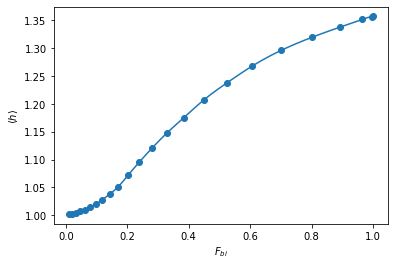

In [99]:
from scipy.interpolate import interp1d

sample = df_bim[df_bim["Λ"] > 5]

grouped_series = sample.groupby("bi_frac").mean()["h"]
bi_frac = grouped_series.index.to_numpy()
h = grouped_series.values
h_interp = interp1d(bi_frac, h, kind='cubic')

@np.vectorize
def h_appr(fbi):
    try:
        return h_interp(fbi)
    except ValueError:
        return 1

fig, ax = plt.subplots()
x = np.linspace(bi_frac.min(), bi_frac.max(), 100)
ax.scatter(bi_frac, h)
ax.plot(x, h_interp(x))
ax.set_xlabel(r"$F_{bi}$")
ax.set_ylabel(r"$\langle h\rangle$")

# fig.savefig("Figures/h_approximation.jpg", dpi=600)

plt.show()

In [127]:
# sample = df_bim[df_bim["Λ"] > 5]

# fig, ax = plt.subplots()
# im = ax.scatter(sample["bi_frac"], sample["h"], s=3, c=sample["l"])
# fig.colorbar(im, label=r"$\ell$")
# ax.set_xlabel(r"$F_{bi}$")
# ax.set_ylabel(r"$\langle h\rangle$")

# # fig.savefig("Figures/hVariation.jpg", dpi=600)

# plt.show()

# for dc in unique_dc:
#     df_plot = sample[sample["dcut"] == dc]
#     if len(df_plot) > 0:
#         fig, ax = plt.subplots()
#         fbi = df_plot["bi_frac"].iloc[0]
#         fbiappr = round(fbi,3)
#         im = ax.scatter(df_plot["l"], df_plot["h"], c=df_plot["Λ"], s=5)
#     #     ax.plot(x, h_appr(fbi)*eta_fit_unim(x), label=rf"$h(F_{{bi}})\cdot\Lambda^{{{round(popt[0],2)}}}$")
#         ax.set_ylim((0,None))
#         ax.set_xlabel(r"$\ell$")
#         ax.set_ylabel(r"$h$")
# #         ax.legend()
#     #     ax.set_xscale('log')
#     #     ax.set_yscale('log')
#         fig.suptitle(rf"$F_{{bi}} = {fbiappr}$")
#     #     fig.savefig(f"Figures/BimEffPlots/Fbi{fbiappr}.jpg")
    
# df_bim_unique_dc = np.unique(df_bim["dcut"])
# for dc in df_bim_unique_dc:
#     fig, ax = plt.subplots()
#     df_plot = df_bim[df_bim["dcut"] == dc]
#     fbi = df_plot["bi_frac"].iloc[0]
#     fbiappr = round(fbi,3)
#     im = ax.scatter(df_plot["Λ"], df_plot["efficiency"], c=df_plot["l"], s=5)
#     fig.colorbar(im, label=r"$\ell$")
#     ax.plot(x, h_appr(fbi)*eta_fit_unim(x), label=rf"$h(F_{{bi}})\cdot\Lambda^{{{round(popt[0],2)}}}$")
#     ax.set_ylim((0,None))
#     ax.set_xlabel(r"$\Lambda$")
#     ax.set_ylabel(r"$\eta$")
#     ax.legend()
# #     ax.set_xscale('log')
# #     ax.set_yscale('log')
#     fig.suptitle(rf"$F_{{bi}} = {fbiappr}$")
#     fig.savefig(f"Figures/BimEffPlotsl/Fbi{fbiappr}.jpg", dpi=600)

<IPython.core.display.Javascript object>


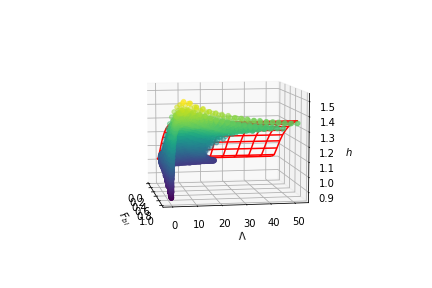

In [23]:
%matplotlib notebook

x = np.linspace(df_bim["bi_frac"].min(), df_bim["bi_frac"].max(), 10)
y = np.linspace(df_bim["Λ"].min(), df_bim["Λ"].max(), 10)
X,Y = np.meshgrid(x,y)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

df_bim["h"] = df_bim["efficiency"] / power(df_bim["Λ"], *popt)

ax.scatter(df_bim["bi_frac"], df_bim["Λ"], df_bim["h"], alpha=0.5, c=df_bim["h"])
ax.plot_wireframe(X,Y,h_appr(X), color="red")
ax.set_xlabel(r"$F_{bi}$")
ax.set_ylabel(r"$\Lambda$")
ax.set_zlabel(r"$h$")

plt.show()
#TODO: average number of passengers on trains

In [129]:
def h_appr(fbi):
    try:
        return h_interp(fbi)
    except ValueError:
        return 1

<IPython.core.display.Javascript object>


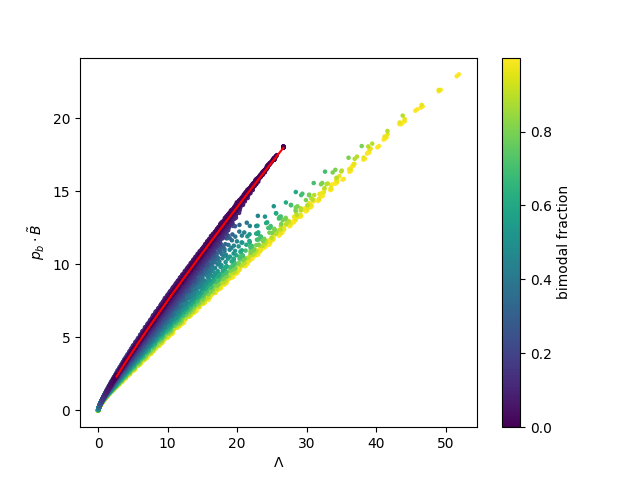

[0.96814504 0.8900868 ]


In [72]:
fig, ax = plt.subplots()

im = ax.scatter(df_served["Λ"], df_served["pbBtilde"], c=df_plot["bi_frac"], s=5)
fig.colorbar(im, label="bimodal fraction")

popt,pcov = curve_fit(power, df_uni["Λ"], df_uni["pbBtilde"])
print(popt)

x = np.linspace(df_uni["Λ"].min(), df_uni["Λ"].max(), 100)
ax.plot(x, power(x,*popt), c="red")

ax.set_xlabel(r"$\Lambda$")
ax.set_ylabel(r"$p_b\cdot \tilde B$")

plt.show()

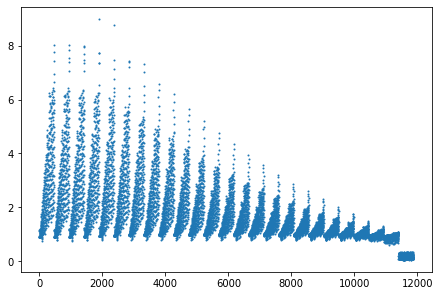

In [255]:
fig, ax = plt.subplots(constrained_layout=True)

ax.scatter(range(len(df_served)), df_served["av_pt_occs"], s=1)

plt.show()

---

In [30]:
# Zs = []
dists = []
reqs = []
pbusys = []

for i,req in enumerate(df_served["requests"].unique()):
    subdf = df_served[df_served["requests"] == req]
    data = subdf.pivot(index="l", columns="dcut", values=["cummulative_dist_drt_unshared",
                                                          "cummulative_dist_drt",
                                                          "idle_frac"])
    Z = data["cummulative_dist_drt_unshared"]/data["cummulative_dist_drt"]
    if i == 0:
        ELL, DCUT = np.meshgrid(Z.index.to_numpy()*subdf["req_mean_dist"].mean(), Z.columns.to_numpy()*subdf["req_mean_dist"].mean(), indexing='ij')
        avDist = (getBimFracAvDist(ELL,DCUT) + getUniFracAvDist(DCUT))/average_dist_theory
#     plt.scatter(avDist, Z.to_numpy())
    reqs.append(req)
    Zs.append(Z)
    dists.append(avDist)
    pbusys.append(1-data["idle_frac"])

# plt.show()

NameError: name 'Zs' is not defined

In [26]:
def linFunc(x,a):
    return a*x

0.0010494198694343006
[5.1733433e-13]
r^2:  0.99203390660234


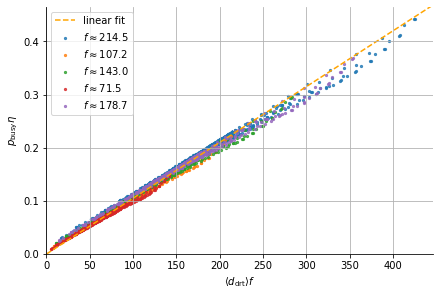

In [27]:
fig, ax = plt.subplots(constrained_layout=True)

sim_timescale = 9*3600 # T_sim [s]
timescale = average_dist_theory/(30/3.6) #<r>/v_drt
x = []
y = []

for Z,avDist,req,pbusy in zip(Zs, dists, reqs, pbusys):
    f = req/sim_timescale*timescale
    plt.scatter(avDist*f, Z.to_numpy()*pbusy, s=5, label=rf"$f \approx {round(f,1)}$", alpha=0.8, zorder=0)
    x.append(avDist*f)
    y.append(Z.to_numpy()*pbusy)

# popt, pcov = curve_fit(linFunc,x[0].flatten(),y[0].to_numpy().flatten())
x = np.concatenate(x).flatten()
y = np.concatenate(y).flatten()

popt, pcov = curve_fit(linFunc,x,y)
print(*popt)
print(*pcov)

cont_x = np.array([0,x.max()*1.1])
plt.plot(cont_x, linFunc(cont_x,*popt), c="orange", ls="--", zorder=1, label="linear fit")
# plt.plot(cont_x, linFunc(cont_x,popt[0]+np.sqrt(np.diag(pcov))[0]), c="red", alpha=0.5, ls="--", zorder=1, label="linear fit")

ax.set_ylim(0,y.max()*1.05)
ax.set_xlim(0,x.max()*1.05)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid()
ax.set_ylabel(r"$p_\mathrm{busy}\eta$")
ax.set_xlabel(r"$\langle d_\mathrm{drt}\rangle f$")
ax.legend()

residuals = y - linFunc(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("r^2: ", r_squared)

# fig.savefig("Figures/EfficiencySupplyDemandCollapsed.pgf")
# fig.savefig("Figures/EfficiencySupplyDemand.pgf")
plt.show()

$$p_\text{busy}\eta = \frac{1}{N v_\text{drt}}\cdot f \langle d_{drt} \rangle$$

In [9]:
print(popt)
print(pcov)
print(np.sqrt(np.diag(pcov)))

[0.00104942]
[[5.1733433e-13]]
[7.19259571e-07]


In [10]:
1/popt[0]

952.907438791929